<a href="https://colab.research.google.com/github/JaquesZanon/JOB/blob/main/escolha_modelos_previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando os dados

In [ ]:
# Precisamos instalar algumas Bibliotecas
!pip install utils
!pip install pmdarima # para autoARIMA
!pip install pyEDM # Para Empirical Dynamic Modeling
!pip install croston
!pip install gluonts # PAra DeepAR
!pip install mxnet # PAra Deep AR
!pip install prophet

In [4]:
# Monta o Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Importa aquivo de texto (.txt)
import pandas as pd
df_original = pd.read_csv('/content/drive/MyDrive/JOB-Martins/DadosPrevisaoDemanda.csv',sep=';', decimal=',', engine='python')

df_original['PrimeiraDataSemana'] = pd.to_datetime(df_original['PrimeiraDataSemana'])
df_original['UltimaDataSemana'] = pd.to_datetime(df_original['UltimaDataSemana'])
df_original = df_original.sort_values(by=['PrimeiraDataSemana'])
df_original.head()


,SiglaUF,DsCategoria,DsSubCategoria,CdGrupoProdutoSimilar,DsGrupoProdutoSimilar,DsMarca,DsDivisaoFornecedor,ANO,PrimeiraDataSemana,UltimaDataSemana,SemanaAno,QtdeVendida,VlTotalBruto,VlTotalLiquido,VlReceitaLiquida,Semanas
0,BA,ACESSORIO ELETRICO,CAIXA DE LUZ,4200765,CXA.LUZ EMB.KRONA 4X2 AM.24X1,Krona,KRONA TUBOS E CONEXOES LTDA.,2020,2020-01-05,2020-01-05,18,1,23.25,23.25,21.10,1
850,BA,SABONETE,SABONETE EM BARRA,205138,SAB.GRANADO 12X90G GLIC.BENJO.,Granado,PONTELAND DISTRIBUICAO SA,2020,2020-01-05,2020-01-05,18,3,129.06,124.92,111.72,1
849,BA,SABONETE,SABONETE EM BARRA,205137,SAB.GRANADO 12X90G GLIC.AMEND.,Granado,PONTELAND DISTRIBUICAO SA,2020,2020-01-05,2020-01-05,18,3,144.30,139.68,124.92,1
848,BA,SABONETE,SABONETE EM BARRA,203130,SAB.GRANADO 12X90G GLIC.MEL,Granado,PONTELAND DISTRIBUICAO SA,2020,2020-01-05,2020-01-05,18,3,144.30,139.68,124.92,1
847,BA,SABONETE,SABONETE EM BARRA,201588,SAB.GRANADO 12X90G GLIC.CALE.,Granado,PONTELAND DISTRIBUICAO SA,2020,2020-01-05,2020-02-05,18,4,164.79,154.57,138.24,1


### Nº

In [3]:
df_original.groupby(['DsDivisaoFornecedor'])[['CdGrupoProdutoSimilar']].nunique().mean()

CdGrupoProdutoSimilar    22.804989
dtype: float64

### Selecionando um distribuidor e um produto similar

In [7]:
dez_mais = df_original.groupby(['DsDivisaoFornecedor'])['QtdeVendida'].sum().sort_values(ascending=False)[:10]
dez_mais

DsDivisaoFornecedor
COTY COSMETICOS                      5794703
ALPARGATAS S/A                       3334742
UNILEVER - CORPO                     2409772
MONDELEZ BRASIL LTDA                 1874003
COLGATE-PALMOLIVE COM.HIG ORAL       1628524
CERAS JOHNSON LTDA - LIMPEZA         1236982
COLGATE PALMOLIVE COM.HIG PESSOAL    1071088
PEPSICO BRASIL LTDA                   973231
KIMBERLY CLARK BRASIL IND COM.        873687
UNILEVER - CABELO                     838758
Name: QtdeVendida, dtype: int64

In [8]:
df_reduzido = df_original[(df_original.DsDivisaoFornecedor==dez_mais.index[0]) | 
            (df_original.DsDivisaoFornecedor==dez_mais.index[1]) |
            (df_original.DsDivisaoFornecedor==dez_mais.index[2]) | 
            (df_original.DsDivisaoFornecedor==dez_mais.index[3]) |
            (df_original.DsDivisaoFornecedor==dez_mais.index[4]) | 
            (df_original.DsDivisaoFornecedor==dez_mais.index[5]) |
            (df_original.DsDivisaoFornecedor==dez_mais.index[6]) | 
            (df_original.DsDivisaoFornecedor==dez_mais.index[7])]

In [9]:
dat_aux = pd.DataFrame(df_original.groupby(['DsDivisaoFornecedor'])['CdGrupoProdutoSimilar'].unique())
dat_aux = pd.DataFrame(df_reduzido.groupby(['DsDivisaoFornecedor'])['CdGrupoProdutoSimilar'].unique())
dat_aux

,CdGrupoProdutoSimilar
DsDivisaoFornecedor,
ALPARGATAS S/A,"[98813, 399, 1218142, 1218136, 1218134, 121812..."
CERAS JOHNSON LTDA - LIMPEZA,"[2100232, 1535, 963, 1700697, 1702263, 97341, ..."
COLGATE PALMOLIVE COM.HIG PESSOAL,"[1336, 106, 205024, 476, 98419, 97251, 97954, ..."
COLGATE-PALMOLIVE COM.HIG ORAL,"[217820, 203780, 202872, 202863, 202862, 20526..."
COTY COSMETICOS,"[773, 98739, 99351, 98744, 1292, 1288, 709, 8,..."
MONDELEZ BRASIL LTDA,"[50, 4300370, 4300369, 579, 97198, 4300067, 10..."
PEPSICO BRASIL LTDA,"[4301422, 4301423, 1665090, 1614900, 4300201, ..."
UNILEVER - CORPO,"[98823, 1011, 97985, 97755, 80059, 10, 1075, 4..."


In [6]:
filter1 = df_original["DsDivisaoFornecedor"]==dat_aux.indexiloc[0,0]
filter2 = df_original['CdGrupoProdutoSimilar']==dat_aux.iloc[0,0][0]
df_0 = df_original[filter1 & filter2]
df = df_0.groupby(['Semanas'])[['QtdeVendida']].sum()
we = pd.DataFrame(list(range(1,65,1)))
we.columns=['Semanas']
we.index=we.Semanas
df = pd.concat([df, we], axis=1)
df=df['QtdeVendida']
df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
df = pd.DataFrame(df).fillna(0)

In [7]:
df

,QtdeVendida
date,
2020-01-05,0.0
2020-01-12,0.0
2020-01-19,0.0
2020-01-26,0.0
2020-02-02,0.0
...,...
2021-02-21,0.0
2021-02-28,32.0
2021-03-07,0.0


In [10]:
from scipy import stats
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_absolute_error
from croston import croston
from prophet import Prophet


In [312]:
filter1 = df_reduzido["DsDivisaoFornecedor"]==dat_aux.index[0]
filter2 = df_reduzido['CdGrupoProdutoSimilar']==dat_aux.iloc[0,0][0]
df_0 = df_reduzido[filter1 & filter2]
df_0

,SiglaUF,DsCategoria,DsSubCategoria,CdGrupoProdutoSimilar,DsGrupoProdutoSimilar,DsMarca,DsDivisaoFornecedor,ANO,PrimeiraDataSemana,UltimaDataSemana,SemanaAno,QtdeVendida,VlTotalBruto,VlTotalLiquido,VlReceitaLiquida,Semanas
870,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2020,2020-01-05,2020-02-05,18,829,14428.95,13867.85,10286.74,1
80033,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2020,2020-02-11,2020-07-11,45,1439,25779.11,24633.13,18320.28,28
1980,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2020,2020-03-05,2020-09-05,19,3585,62482.92,60201.84,44753.99,2
43861,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2020,2020-03-08,2020-08-08,32,2597,46486.75,44884.31,33336.95,15
69635,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2020,2020-05-10,2020-10-10,41,2307,41751.04,39800.67,29585.28,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129921,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2021,2021-07-03,2021-03-13,11,1325,24558.69,22759.73,16934.36,47
170131,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2021,2021-07-06,2021-12-06,24,8983,174723.63,163779.99,121572.13,60
158233,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2021,2021-10-05,2021-05-15,20,2556,40616.69,37037.38,25463.20,56
108104,BA,SANDALIA,ALOHA,98813,SAND.HAV.ALOHA,Havaianas,ALPARGATAS S/A,2021,2021-11-01,2021-01-16,3,1437,26146.68,24730.24,18390.01,39


In [316]:
len(dat_aux.iloc[0,0])

946

In [ ]:
par={}
erro={}
par_croston={}
erro_croston={}
erro_prophet={}



for j in range(0, 7):
   for i in range(0,len(dat_aux.iloc[j,0])):
   # Selecionando os dados para ajustar os modelos
      filter1 = df_reduzido["DsDivisaoFornecedor"]==dat_aux.index[j]
      filter2 = df_reduzido['CdGrupoProdutoSimilar']==dat_aux.iloc[j,0][i]
      df_0 = df_reduzido[filter1 & filter2]
      df = df_0.groupby(['Semanas'])[['QtdeVendida']].sum()
      we = pd.DataFrame(list(range(1,65,1)))
      we.columns=['Semanas']
      we.index=we.Semanas
      df = pd.concat([df, we], axis=1)
      df=df['QtdeVendida']
      df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
      df = pd.DataFrame(df).fillna(0)

      # Substituindo outliers
      z = np.abs(stats.zscore(df.QtdeVendida))
      median=df.QtdeVendida.median()
      df["QtdeVendida"] = np.where(z>3, median, df["QtdeVendida"])

      # Sets de treino e teste
      train_len = int(df.shape[0] * 0.7)
      train_data, test_data = df[:train_len], df[train_len:]

      # Ajustando AutoArima
      stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
   
      # Armazenando resultados AutoArima
      sentence = [str(dat_aux.index[j]) , str(dat_aux.iloc[j,0][i])]
      sentence = '-'.join(sentence)
      #aux = stepwise_fit.get_params()
      #par[sentence]=aux
      #forecasts = stepwise_fit.predict(test_data.shape[0])  # predict N steps into the future
      #mmae = mean_absolute_error(test_data, forecasts)
      #erro[sentence]=mmae
  
      # Ajustando modelo Croston
      croston_pred = croston.fit_croston(df+0.000001,test_data.shape[0],'original')

      # Armazenando resultados Croston
      par_croston[sentence]=croston_pred
      erro_croston[sentence] = mean_absolute_error(test_data, croston_pred['croston_forecast'])

      # O modelo profet só funciona com duas colunas
      y = df.reset_index(drop=False)
      y.columns = ['ds', 'y']
      y['floor'] = 0
      y['cap'] = 2000
      train = y.iloc[:train_data.shape[0],:]
      test = y.iloc[train_data.shape[0]:,:]

      #Ajustando modelo Prophet
      m = Prophet()
      m.fit(train)
      future = m.make_future_dataframe(periods=len(test))
      future['ds'] = pd.to_datetime(future['ds']).dt.date
      forecast = m.predict(future)
      erro_prophet[sentence] = mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

pd.DataFrame.from_dict(erro_prophet,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/prophet.csv')
pd.DataFrame.from_dict(erro_croston,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/croston.csv')
pd.DataFrame.from_dict(erro,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/arima.csv')

In [14]:
pd.DataFrame.from_dict(erro_prophet,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/prophet.csv')


In [ ]:
erro_prophet

In [215]:
# O modelo profet só funciona com duas colunas
y = df.reset_index(drop=False)
y.columns = ['ds', 'y']
y['floor'] = 0
y['cap'] = 2000
train = y.iloc[:train_data.shape[0],:]
test = y.iloc[train_data.shape[0]:,:]

In [227]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=len(test))
future['ds'] = pd.to_datetime(future['ds']).dt.date
forecast = m.predict(future)
mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

In [228]:
m.fit(train)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [233]:
future = m.make_future_dataframe(periods=len(test))
future['ds'] = pd.to_datetime(future['ds']).dt.date
forecast = m.predict(future)
mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

1.9036096749922158

### Instalando algumas Biblioecas

In [ ]:
# Precisamos instalar algumas Bibliotecas
!pip install utils
!pip install pmdarima # para autoARIMA
!pip install pyEDM # Para Empirical Dynamic Modeling
!pip install croston
!pip install gluonts # PAra DeepAR
!pip install mxnet # PAra Deep AR

### Ralace Outliers with median

In [ ]:
df

,QtdeVendida
date,
2020-01-05,0.0
2020-01-12,0.0
2020-01-19,0.0
2020-01-26,0.0
2020-02-02,0.0
...,...
2021-02-21,0.0
2021-02-28,32.0
2021-03-07,0.0


In [9]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df.QtdeVendida))
#threshold = 3
print(np.where(z > 3))
median=df.QtdeVendida.median()
df["QtdeVendida"] = np.where(z>3, median, df["QtdeVendida"])


(array([60]),)


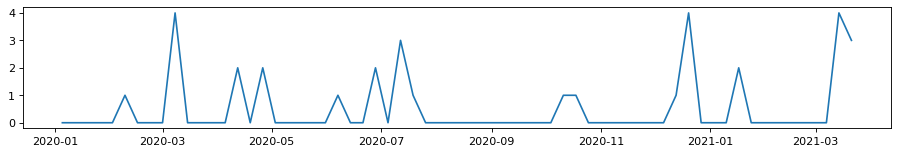

In [10]:
# Figura Geral
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

figure(figsize=(14, 2), dpi=80)
plt.plot(df)
plt.show()

### Separando Treino e Teste

In [11]:
train_len = int(df.shape[0] * 0.7)
train_data, test_data = df[:train_len], df[train_len:]
print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

44 train samples
20 test samples


In [77]:
#stepwise_fit.summary()
par = stepwise_fit.get_params()
par = pd.DataFrame.from_dict(par,orient='index')
par.columns = [dat_aux.iloc[0,0][0]]
par.insert(1, dat_aux.iloc[0,0][1], par)

,805,97145
maxiter,50,50
method,lbfgs,lbfgs
order,"(1, 1, 1)","(1, 1, 1)"
out_of_sample_size,0,0
scoring,mse,mse
scoring_args,{},{}
seasonal_order,"(2, 1, 1, 12)","(2, 1, 1, 12)"
start_params,None,None
suppress_warnings,True,True
trend,None,None


In [12]:
import pmdarima as pm
#fitting a stepwise model:
stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=140.066, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=117.245, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=120.299, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=108.716, Time=0.53 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=106.664, Time=0.62 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(

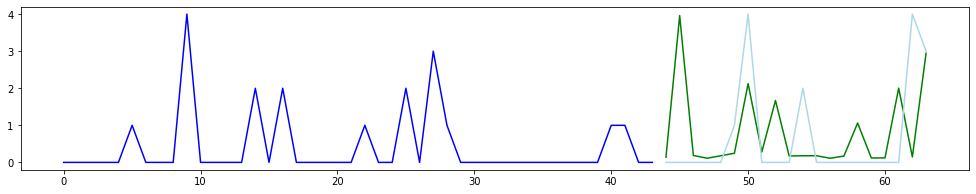

0.9413967601176487


In [ ]:
from sklearn.metrics import mean_absolute_error
# make your forecasts to test data
forecasts = stepwise_fit.predict(test_data.shape[0])  # predict N steps into the future

x = np.arange(df.shape[0])
plt.figure(figsize=(17,3))
plt.plot(x[:train_data.shape[0]], train_data, c='blue')
plt.plot(x[train_data.shape[0]:], forecasts, c='green')
plt.plot(x[train_data.shape[0]:], test_data, c='lightblue')
plt.show()
print(mean_absolute_error(test_data, forecasts))

### Modelo Croston

In [ ]:
from croston import croston

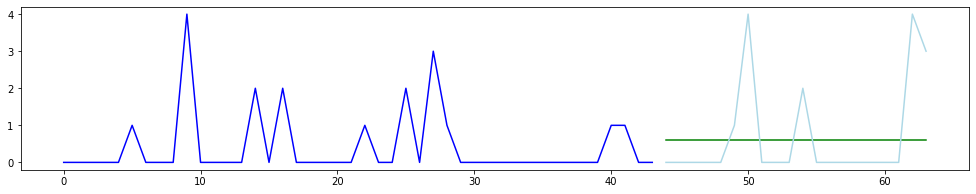

0.9989402050266951


In [ ]:
fit_pred = croston.fit_croston(df,test_data.shape[0],'original')

x = np.arange(df.shape[0])
plt.figure(figsize=(17,3))
plt.plot(x[:train_data.shape[0]], train_data, c='blue')
plt.plot(x[train_data.shape[0]:], fit_pred['croston_forecast'], c='green')
plt.plot(x[train_data.shape[0]:], test_data, c='lightblue')
plt.show()
print(mean_absolute_error(test_data, fit_pred['croston_forecast']))

### Modelo Prophet

In [ ]:
df

,QtdeVendida
date,
2020-01-05,0.0
2020-01-12,0.0
2020-01-19,0.0
2020-01-26,0.0
2020-02-02,0.0
...,...
2021-02-21,0.0
2021-02-28,0.0
2021-03-07,0.0


In [ ]:
# O modelo profet só funciona com duas colunas
y = df.reset_index(drop=False)
y.columns = ['ds', 'y']
y['floor'] = 0
y['cap'] = 2000
train = y.iloc[:train_data.shape[0],:]
test = y.iloc[train_data.shape[0]:,:]

In [ ]:
# Função para o grid search
def model_test(holidays, weekly_seasonality,yearly_seasonality, add_monthly, add_reserve, changepoint_prior_scale, holidays_prior_scale, month_fourier):
    m = Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            holidays=holidays,
            changepoint_prior_scale=changepoint_prior_scale,
            holidays_prior_scale=holidays_prior_scale)
    if add_monthly:
        m.add_seasonality(
            name='monthly',
            period=7,
            fourier_order=month_fourier)
    if add_reserve:
        m.add_regressor('reserve_visitors')
    m.fit(train)
    future = m.make_future_dataframe(periods=len(test))
    future['ds'] = pd.to_datetime(future['ds']).dt.date
    if add_reserve:
        future = future.merge(
            X_reservations,
            left_on = 'ds',
            right_on = 'visit_date',
            how = 'left')
        future = future[['ds', 'reserve_visitors']]
        future = future.fillna(0)
    forecast = m.predict(future)

    return mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

In [ ]:
# Setting the grid
growth = ['logistic']
holidays_opt = [None]
weekly_seas = ["auto"]
yearly_seas = ["auto"]
add_monthly = [False]
add_reserve = [False]
changepoint_prior_scale = [ 0.3, 0.5]
holidays_prior_scale = [0.3, 0.5]
month_fourier = [10]

In [ ]:
# Looping through the grid
from fbprophet import Prophet
from sklearn.metrics import r2_score
grid_results = []

for h in holidays_opt:
  for w in weekly_seas:
    for ys in yearly_seas:
      for m in add_monthly:
        for r in add_reserve:
          for c in changepoint_prior_scale:
            for hp in holidays_prior_scale:
              for mf in month_fourier:
                r2=model_test(h,w,ys,m,r,c,hp,mf)
                print([h,w,ys,m,r,c,hp,mf,r2])
                grid_results.append([h,w,ys,m,r,c,hp,mf,r2])
# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)
h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[None, 'auto', 'auto', False, False, 0.3, 0.3, 10, 0.9280640532677952]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[None, 'auto', 'auto', False, False, 0.3, 0.5, 10, 0.9280640532677952]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[None, 'auto', 'auto', False, False, 0.5, 0.3, 10, 0.926632490406585]
[None, 'auto', 'auto', False, False, 0.5, 0.5, 10, 0.926632490406585]


In [ ]:
m = Prophet(
            yearly_seasonality=ys,
            weekly_seasonality=w,
            holidays=h,
            changepoint_prior_scale=c,
            holidays_prior_scale=hp)
if m:
    m.add_seasonality(
            name='monthly',
            period=7,
            fourier_order=mf)
if r:
    m.add_regressor('reserve_visitors')
m.fit(train)
future = m.make_future_dataframe(periods=len(test))
future['ds'] = pd.to_datetime(future['ds']).dt.date
if r:
    future = future.merge(
            X_reservations,
            left_on = 'ds',
            right_on = 'visit_date',
            how = 'left')
    future = future[['ds', 'reserve_visitors']]
    future = future.fillna(0)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.3063485157230177


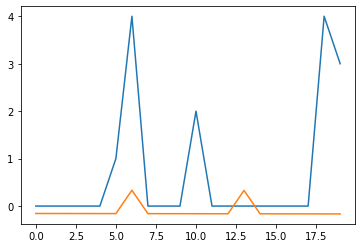

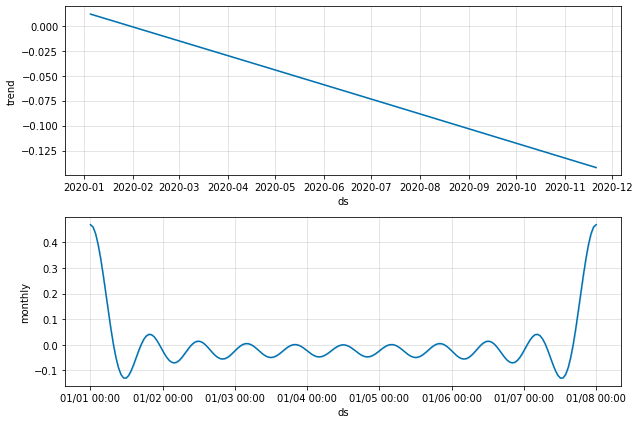

In [ ]:
print(r2_score(list(test['y']), list(forecast.loc[train_data.shape[0]:,'yhat'] )))
plt.plot(list(test['y']))
plt.plot(list(forecast.loc[train_data.shape[0]:,'yhat'] ))
fig2 = m.plot_components(forecast)
plt.show()

### DeepAR

In [ ]:
test_ds

In [ ]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("01-05-2020", freq="H")
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': y.loc[train.shape[0]:,'y'], 'start': start}], freq='H')
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': y['y'], 'start': start}], freq='H')

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx
import numpy as np
np.random.seed(7)
mx.random.seed(7)
estimator = DeepAREstimator(prediction_length=test.shape[0], context_length=100, freq='H', trainer=Trainer(ctx="cpu", # remove if running on windows
                                                                                                epochs=5,learning_rate=1e-3,num_batches_per_epoch=100) 
)
predictor = estimator.train(train_ds)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:20<00:00,  4.96it/s, epoch=1/5, avg_epoch_loss=-4.38]
INFO:gluonts.trainer:Epoch[0] Elapsed time 20.153 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=-4.381917
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.11it/s, epoch=2/5, avg_epoch_loss=-5.93]
INFO:gluonts.trainer:Epoch[1] Elapsed time 19.560 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=-5.931420
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.09it/s, epoch=3/5, avg_epoch_loss=-6.38]
INFO:gluonts.trainer:Epoch[2] Elapsed time 19.645 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=-6.381522
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.12it/s, epoch=4/5, avg_epoch_loss=-6.66]
INFO:gluonts.trainer:Epoch[

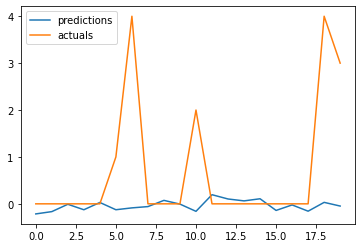

0.79308236


In [ ]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-20:])
plt.legend(['predictions', 'actuals'])
plt.show()
print(mean_absolute_error(list(test_ds)[0]['target'][-20:], predictions))

In [ ]:
list(train_ds)[0]['target']

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 170.01,   0.  ,
         0.  , 120.02,   0.  ,   0.  ,  44.99,   0.  ,   0.  , 255.96,
         0.  , 480.01,   0.  ,  24.99,   0.  ,   0.  , 529.96, 128.99,
         0.  ,   0.  , 200.01,   0.  ,   0.  ,   0.  , 160.04,   0.  ,
       139.99,   0.  ,  80.02,   0.  ,  92.99, 240.04, 220.01,   0.  ,
        80.02,   0.  ,   0.  ,   0.  ,  80.02, 189.99,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  , 145.01, 110.02,  39.99,  85.02, 225.04,
        79.99,  80.02, 119.99,   0.  , 160.04, 360.02,   0.  ,   0.  ,
       450.02, 380.06,   0.  ,   0.  ,  12.  ,   0.  , 229.99,   0.  ,
       305.04,   0.  ,  30.  ,   0.  ,   0.  ,   0.  ,  45.  ,   0.  ,
        24.99, 119.96, 199.01,   0.  ,   0.  ,   0.  , 120.  ,  80.02,
         0.  , 189.98,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
        79.99,   0.  , 228.99, 210.01, 414.96, 394.97, 109.99, 109.99,
       469.96,   0.  ,   0.  ,  54.99, 304.98, 229.98,  79.99, 429.97,
      

### EDM

In [ ]:
import pyEDM

In [ ]:
y

,ds,y,floor,cap
0,2020-01-05,0.0,0,2000
1,2020-01-12,0.0,0,2000
2,2020-01-19,0.0,0,2000
3,2020-01-26,0.0,0,2000
4,2020-02-02,0.0,0,2000
...,...,...,...,...
59,2021-02-21,0.0,0,2000
60,2021-02-28,0.0,0,2000
61,2021-03-07,0.0,0,2000
62,2021-03-14,4.0,0,2000


In [ ]:
y

,Time,Revenue
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
...,...,...
59,60,0.0
60,61,0.0
61,62,0.0
62,63,4.0


In [ ]:
y = y[["ds","y"]]
y.columns = ["Time", "Revenue"]
y.Time = list(range(1,df.shape[0]+1,1))

KeyError: ignored

In [ ]:
aaa=pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=False)
frame(aaa.ewm)


NameError: ignored

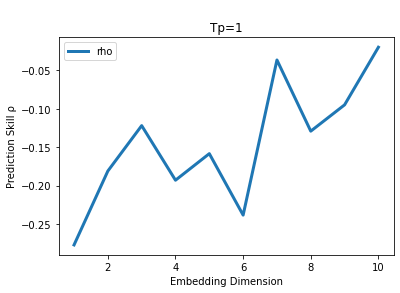

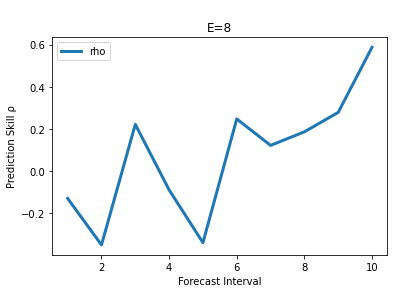

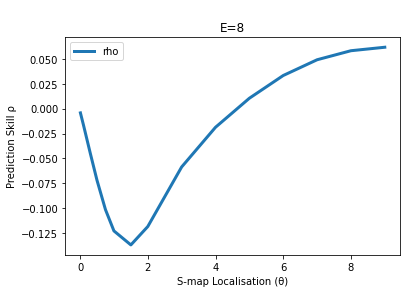

In [ ]:
pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue");
pyEDM.PredictInterval(dataFrame = y,lib="1 44", pred="45 64", columns="Revenue", E=8, showPlot=True);
pyEDM.PredictNonlinear(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue", E=8);

{'MAE': 76.75922374379553, 'RMSE': 110.85803388275225, 'rho': 0.9397499713920134}


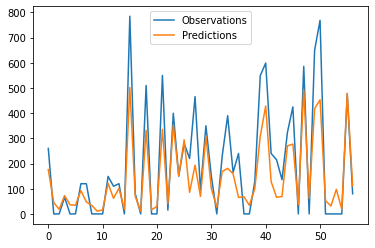

In [ ]:
simplex_pred = pyEDM.Simplex(dataFrame = y,lib="1 44", pred="45 64", E=8, columns="Revenue",Tp=0,tau=-3)
print(pyEDM.ComputeError(simplex_pred['Observations'],simplex_pred['Predictions']))
simplex_pred[['Observations', 'Predictions']].plot()